# IRCUR

Paper: https://arxiv.org/pdf/2010.07422.pdf

Matlab Script: https://github.com/caesarcai/IRCUR/blob/master/IRCUR.m

Full Repository: https://github.com/caesarcai/IRCUR

Related paper that is more recent: https://arxiv.org/pdf/2206.09042.pdf (on Riemannian CUR)

In [2]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.set_printoptions(precision=3, sci_mode=True)

## ======================== Parameters ========================
d1 = 100                   # num. of rows
d2 = 70                   # num. of columns
max_iter = 100              # num. of layers trained
r = 2
alpha = 0.3

In [4]:
## Code to generate data for RPCA problem. References:
## https://github.com/caesarcai/LRPCA/blob/main/synthetic_data_exp/training_codes.py 
## https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/test_AccAltProj.m

def generate_problem(r,d1,d2,alpha, c):
    U0_t 		= torch.randn(d1,r)
    V0_t 		= torch.randn(d2,r)
    L0_t 		= U0_t @ V0_t.t()
    idx 		= torch.randperm(d1*d2)
    idx 		= idx[:math.floor(alpha * d1*d2)]
    s_range		= c * torch.mean(torch.abs(L0_t))
    S0_tmp 		= torch.rand(d1 * d2)
    S0_tmp 		= s_range * (2.0 * S0_tmp - 1.0)
    S0_t        = torch.zeros(d1 * d2)
    S0_t[idx]   = S0_tmp[idx]
    S0_t        = S0_t.reshape((d1,d2))
    Y0_t        = L0_t + S0_t
    return L0_t, S0_t, Y0_t

## Classical

In [5]:
def thres(inputs, threshold, hard=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- threshold, torch.zeros([1,1]))
    else:
        out = torch.sign(inputs) * (nn.Threshold(threshold, 0)(torch.abs(inputs)))
    return out

## resampling function
def resample(m, n, siz_row, siz_col):
    rows = np.random.randint(0, m, size=[1, siz_row])
    cols = np.random.randint(0, n, size=[1, siz_col])
    return [np.unique(rows), np.unique(cols)]

def IRCUR(M0, r, tol, gamma, con, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    siz_row, siz_col = np.ceil(con * r * np.log(m)).astype(np.int64), np.ceil(con * r * np.log(n)).astype(np.int64)
    zeta = torch.max(torch.abs(M0))
    C, pinv_U, R = torch.zeros(M0.shape), torch.zeros([M0.shape[1], M0.shape[0]]), torch.zeros(M0.shape)
    for t in range(max_iter):
        ## resample rows and columns
        rows, cols = resample(m, n, siz_row, siz_col)
        M0_rows = M0[rows, :]
        M0_cols = M0[:, cols]
        norm_of_M0 = torch.linalg.norm(M0_rows) + torch.linalg.norm(M0_cols)
        ## compute submatrices of L from previous iteration
        L_rows = C[rows, :] @ pinv_U @ R
        L_cols = C @ pinv_U @ R[:, cols]
        ## update S using submatrices of L
        S_rows = thres(M0_rows - L_rows, zeta)
        S_cols = thres(M0_cols - L_cols, zeta)
        ## update L
        C = M0_cols - S_cols
        R = M0_rows - S_rows
        MU = C[rows, :]
        U,Sigma,Vh = torch.linalg.svd(MU, full_matrices=False)
        ## calculate Moore-Penrose inverse of Sigma
        pinv_U = Vh.t()[:,:r] @ torch.diag(1./Sigma[:r]) @ U[:, :r].t()
        ## update zeta
        zeta = gamma * zeta
        ## update loss
        err = (torch.linalg.norm(M0_rows - L_rows - S_rows) + torch.linalg.norm(M0_cols - L_cols - S_cols))/ norm_of_M0
        loss.append(err)
        if err < tol:
            L = C @ pinv_U @ R
            S = M0 - L
            return loss, L, S
    L = C @ pinv_U @ R
    S = M0 - L
    return loss, L, S

In [6]:
## generate data
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha, c=1)

In [7]:
## start with M_true, assuming known rank
## error tolerance = 1e-6, gamma = 0.7, sampling constant = 3, max_iter = 100
loss, L_hat, S_hat = IRCUR(M_true, r, 1e-6, torch.tensor(0.7), 3, max_iter)

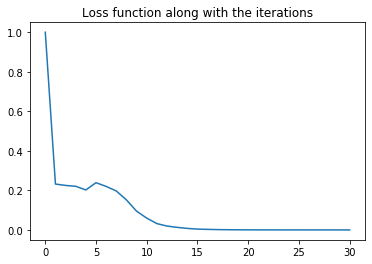

tensor(8.427e-07)
tensor(7.268e-07)
tensor(1.615e-05)


In [8]:
plt.plot(loss)
plt.title('Loss function along with the iterations')
plt.show()

print(loss[-1])
print(torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print(torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

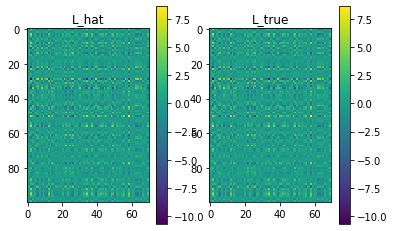

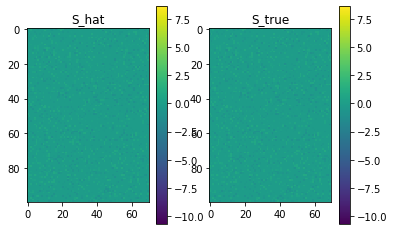

In [9]:
combined = torch.cat((L_hat, L_true, S_hat, S_true)) ## combine matrices so that colorbars can be standardized

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(L_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("L_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(L_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("L_true")
plt.colorbar(im2, ax=ax2)
plt.show()

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(S_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("S_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(S_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("S_true")
plt.colorbar(im2, ax=ax2)
plt.show()

## Unrolled version

In [47]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

# ======================== One Layer of the NN ========================
class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r, con):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        siz_row, siz_col = np.ceil(con * r * np.log(m)).astype(np.int64), np.ceil(con * r * np.log(n)).astype(np.int64)
        rows, cols = np.random.randint(0, m, size=[1, siz_row]), np.random.randint(0, n, size=[1, siz_col])
        rows, cols = np.unique(rows), np.unique(cols)
        C, pinv_U, R = torch.zeros([M0.shape[0], siz_col]), torch.zeros([siz_col, siz_row]), torch.zeros([siz_row, M0.shape[1]])
        zeta_init = torch.max(torch.abs(M0))
        return C, pinv_U, R, zeta_init, rows, cols
class ProjStage(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
    def resample(self, m, n, siz_row, siz_col):
        rows = np.random.randint(0, m, size=[1, siz_row])
        cols = np.random.randint(0, n, size=[1, siz_col])
        return [np.unique(rows), np.unique(cols)]
    def thres(self, inputs, threshold, hard=True):
        if not hard:
            out = torch.sign(inputs) * torch.max(torch.abs(inputs)- threshold, torch.zeros([1,1]))
        else:
            out = inputs * (torch.abs(inputs) > threshold)
        return out
    def forward(self, M0, r, C, pinv_U, R, zeta_init, rows, cols):
        ## Update S
        zeta = self.gamma * zeta_init

        M0_rows = M0[rows, :]
        M0_cols = M0[:, cols]
        norm_of_M0 = torch.linalg.norm(M0_rows) + torch.linalg.norm(M0_cols)
        L_rows = C[rows, :] @ pinv_U @ R
        L_cols = C @ pinv_U @ R[:, cols]
        S_rows = self.thres(M0_rows - L_rows, zeta, hard=False)
        S_cols = self.thres(M0_cols - L_cols, zeta, hard=False)

        ## Update L
        C = M0_cols - S_cols
        R = M0_rows - S_rows
        MU = C[rows, :]
        U,Sigma,Vh = torch.linalg.svd(MU, full_matrices=False)
        ## calculate Moore-Penrose inverse of Sigma
        pinv_U = Vh.t()[:,:r] @ torch.diag(1./Sigma[:r]) @ U[:, :r].t()
        
        ## Compute err using previous L and current S
        err = (torch.linalg.norm(M0_rows - L_rows - S_rows) + torch.linalg.norm(M0_cols - L_cols - S_cols))/ norm_of_M0
        ## Resample rows and cols
        rows, cols = resample(M0.shape[0], M0.shape[1], len(rows), len(cols))
        return C, pinv_U, R, zeta, rows, cols, err

## ======================== Full NN with layers stacked ========================
class LearnedIRCUR(nn.Module):
    def __init__(self, max_iter, gamma):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = gamma
        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
        self.layers=nn.Sequential(*self.layer) ## stack layers together
        ## Track loss
        self.loss = torch.zeros(max_iter)
    
    def forward(self, M0, r, con):
        lay_init = self.layers[0]
        C, pinv_U, R, zeta_init, rows, cols = lay_init(M0, r, con)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            C, pinv_U, R, zeta, rows, cols, err = lay(M0, r, C, pinv_U, R, zeta_init, rows, cols)
            #print(zeta)
            self.loss[t-1] = err
        L = C @ pinv_U @ R
        return L, M0-L, err

In [48]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
r = 2

In [49]:
## generate data
alpha_true = 0.3
c_true = 1
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha_true, c_true)

In [50]:
net = LearnedIRCUR(max_iter, gamma=torch.tensor(0.7))
L_bftrain, S_bftrain, err_bftrain = net(M_true, r, con=3) # assumes knowledge of rank
lossbftrain=np.array(net.loss.detach().numpy())
print(lossbftrain[-1])

5.5826486e-06


In [51]:
optimizer=Adam(net.parameters(), lr=1e-5)

nepochs = 100
for epoch in range(nepochs):  # loop over the dataset multiple times

    for i in range(50):
        L0, S0, M0 = generate_problem(r, d1, d2, alpha_true, c_true)
        optimizer.zero_grad()
        L_hat, S_hat, err = net(M0, r, con=3)
        loss = err + torch.linalg.norm(L0 - L_hat)/torch.linalg.norm(L0) + torch.linalg.norm(S0 - S_hat)/torch.linalg.norm(S0)
        #loss = err
        loss.backward()
        for name, param in net.named_parameters():
            if not torch.isfinite(param.grad).all():
                print(name, torch.isfinite(param.grad).all())
                break
        ## ISSUE: the gradient computed for some parameters become nan after calling backward()
        optimizer.step()
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))

print('Finished Training')

Epoch 1/100 at cost=0.0013953447341918945
Epoch 2/100 at cost=0.002053195144981146
Epoch 3/100 at cost=0.0024377109948545694
Epoch 4/100 at cost=0.0013071115827187896
Epoch 5/100 at cost=0.0016273315995931625
Epoch 6/100 at cost=0.0018920623697340488
Epoch 7/100 at cost=0.0013679580297321081
Epoch 8/100 at cost=0.0015343924751505256
Epoch 9/100 at cost=0.0017119867261499166
Epoch 10/100 at cost=0.0012563165510073304
Epoch 11/100 at cost=0.0052612037397921085
Epoch 12/100 at cost=0.0037670228630304337
Epoch 13/100 at cost=0.0014442369574680924
Epoch 14/100 at cost=0.001688779448159039
Epoch 15/100 at cost=0.0016324567841365933
Epoch 16/100 at cost=0.0006507404032163322
Epoch 17/100 at cost=0.002149979118257761
Epoch 18/100 at cost=0.0015933758113533258
Epoch 19/100 at cost=0.0008415399352088571
Epoch 20/100 at cost=0.0034468737430870533
Epoch 21/100 at cost=0.0013345860643312335
Epoch 22/100 at cost=0.0013604392297565937
Epoch 23/100 at cost=0.0050738174468278885
Epoch 24/100 at cost=0.

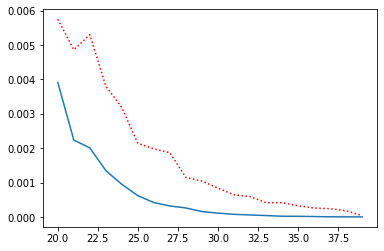

Before train
||L - L_hat||F: tensor(6.306e-04, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(1.740e-02, grad_fn=<DivBackward0>)
After train
||L - L_hat||F: tensor(1.965e-04, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(3.101e-03, grad_fn=<DivBackward0>)


In [52]:
L_hat, S_hat, err = net(M_true, r, con=3)
plt.plot(range(max_iter)[20:],net.loss.detach().numpy()[20:],'r:',label='Loss after training')
plt.plot(range(max_iter)[20:],lossbftrain[20:],label='Loss before training')
plt.show()
print("Before train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_bftrain)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_bftrain, 1)/ torch.linalg.norm(S_true, 1))
print("After train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

In [53]:
print("Before train: ", lossbftrain[-1])
print("After train: ", net.loss.detach().numpy()[-1])

Before train:  5.5826486e-06
After train:  4.274162e-05


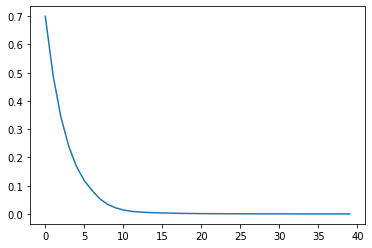

In [54]:
plt.plot([x.detach().numpy() for x in list(net.parameters())])

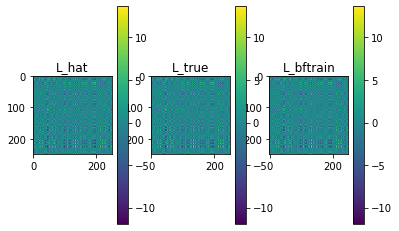

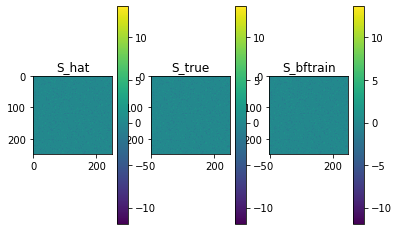

In [55]:
combined = torch.cat((L_hat, L_true, S_hat, S_true)) ## combine matrices so that colorbars can be standardized

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
im1 = ax1.imshow(L_hat.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("L_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(L_true.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("L_true")
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(L_bftrain.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax3.set_title("L_bftrain")
plt.colorbar(im3, ax=ax3)
plt.show()

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
im1 = ax1.imshow(S_hat.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("S_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(S_true.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("S_true")
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(S_bftrain.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax3.set_title("S_bftrain")
plt.colorbar(im3, ax=ax3)
plt.show()

## when dimension of matrix is large (2500 x 2500)

In [56]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 2500                   # num. of rows
d2 = 2500                   # num. of columns
max_iter = 40              # num. of layers trained
r = 5
## generate data
alpha_true = 0.3
c_true = 1
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha_true, c_true)
net = LearnedIRCUR(max_iter, gamma=torch.tensor(0.7))
L_bftrain, S_bftrain, err_bftrain = net(M_true, r, con=3) # assumes knowledge of rank
lossbftrain=np.array(net.loss.detach().numpy())
print(lossbftrain[-1])

3.6657202e-06


In [57]:
#optimizer=Adam(net.parameters(), weight_decay=0.9)
optimizer=Adam(net.parameters(), lr=1e-5)

nepochs = 100
for epoch in range(nepochs):  # loop over the dataset multiple times

    for i in range(50):
        L0, S0, M0 = generate_problem(r, d1, d2, alpha_true, c_true)
        optimizer.zero_grad()
        L_hat, S_hat, err = net(M0, r, con=3)
        loss = err + torch.linalg.norm(L0 - L_hat)/torch.linalg.norm(L0) + torch.linalg.norm(S0 - S_hat)/torch.linalg.norm(S0)
        #loss = err
        loss.backward()
        for name, param in net.named_parameters():
            if not torch.isfinite(param.grad).all():
                print(name, torch.isfinite(param.grad).all())
                break
        ## ISSUE: the gradient computed for some parameters become nan after calling backward()
        optimizer.step()
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))

print('Finished Training')

layers.6.gamma tensor(False)

Intel MKL ERROR: Parameter 4 was incorrect on entry to SLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to SLASCL.


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 24).

In [ ]:
L_hat, S_hat, err = net(M_true, r, con=3)
plt.plot(range(max_iter)[20:],net.loss.detach().numpy()[20:],'r:',label='Loss after training')
plt.plot(range(max_iter)[20:],lossbftrain[20:],label='Loss before training')
plt.show()
print("Before train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_bftrain)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_bftrain, 1)/ torch.linalg.norm(S_true, 1))
print("After train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))